# Set Environment & Globals

You'll need all packages installed:
* `seaborn` plotting
* `pandas` dataframes
* `scanpy` for single-cell analysis
* `spatialdata[extra]` spatial analysis
* `glasbey` for prettier colors
* `rpy2` (R ↔ Python)
* `anndata2ri` (R ↔ Python)

I use [`rye`](https://rye.astral.sh/guide/installation), which is lightweight and simple to use, but plain old `pip install` or `conda`/`mamba` (and other package managers like `poetry` are equally useful).

In [ ]:
# %load_ext jupyter_black

# base
import os
import sys
import warnings
import logging

# from tqdm import tqdm

logging.basicConfig(level="INFO")
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

# data manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter("ignore", pd.errors.DtypeWarning)
mlogger = logging.getLogger("matplotlib")
mlogger.setLevel(logging.WARNING)

# single cell
import scanpy as sc
import spatialdata as sd

# custom
from spatial_seq.R import *

# R
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
# IMPORTANT: When using R in Python for single cell data, make sure to limit the amount that's printed.
# See the `R_preload()` function as an example
R_preload()

converter = get_converter()
%load_ext rpy2.ipython

Attaching package: ‘dplyr’

  

    filter, lag

  

    intersect, setdiff, setequal, union

  
  
  
  
  
  
Attaching package: ‘matrixStats’

  

    count

  
Attaching package: ‘MatrixGenerics’

  

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiff


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Attaching package: ‘Seurat’

  

    Assays

  


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
# analysis & device specific
%matplotlib inline
CORES = 10
DATADIR = "../../data"
REFDIR = "../../references"

# Load data

My notebook's directory is in /mnt/DATA/home/ethung/spatial_seq/**<u>src/notebooks/</u>**

My data's directory is in /mnt/DATA/home/ethung/spatial_seq/**<u>data/processed/external/</u>**

In [ ]:
# find data
print("Current directory:", os.getcwd())
print("Data directory: ", os.path.join(DATADIR, "processed", "external"))
print(
    "Checking for files in data directory:",
    os.listdir(os.path.join(DATADIR, "processed", "external")),
)

seurat_obj_name = "CU048_ConfPositioned_seurat_spatial_merged.rds"
filedir = os.path.join(DATADIR, "processed", "external", seurat_obj_name)

# must use this converter whenever passing objects between R & Python
with localconverter(converter): 
    ro.globalenv["rds_file"] = filedir

Current directory: /mnt/DATA/home/ethung/spatial_seq/src/notebooks
Data directory:  ../../data/processed/external
Checking for files in data directory: ['CU048_ConfPositioned_seurat_spatial_merged.rds']


In [ ]:
%%R
# this is called a magic function, and is available through the `rpy2` package. It allows you to run R code in a Jupyter notebook.

library(Seurat)
print(rds_file)
# read in data
Seurat_obj <- readRDS(file = rds_file)

[1] "../../data/processed/external/CU048_ConfPositioned_seurat_spatial_merged.rds"


In [ ]:
%%R
### NOTE: Image was not available in the seurat object file shared. Verified by GetImage & SpatialDimPlot(). Metadata might be corrupted and/or class data is not availble.

# # Get image, see https://github.com/satijalab/seurat/issues/8334

# library(terra)
# # DefaultAssay(Seurat_obj) <- 'SCT'
# image_vis <- SeuratObject::GetImage(Seurat_obj, mode = "raw") %>%
#     as.matrix %>% 
#     terra::rast()
# image_vis %>% plot
# # export as .png or .tif
# writeRaster(image_vis, here("data", "processed", "external"))

In [ ]:
%%R 
# convert into a SingleCellExperiment. `anndata2ri` allows automatic interconversion
DefaultAssay(Seurat_obj) <- 'SCT'
sce_SCT <- as.SingleCellExperiment(Seurat_obj)
DefaultAssay(Seurat_obj) <- 'RNA'
sce_RNA <- as.SingleCellExperiment(Seurat_obj)
spatial_coords <- Embeddings(Seurat_obj, reduction = "SPATIAL")

In [ ]:
# send the SingleCellExperiment objects to AnnData objects in Python
with localconverter(converter):
    adata_SCTtransformed = ro.globalenv["sce_SCT"]
    adata = ro.globalenv["sce_RNA"]
    spatial = ro.globalenv["spatial_coords"] # spatial coords get loss for some reason

print(
    f"SCTransform'd object:\t{adata_SCTtransformed.shape[0]} cells X {adata_SCTtransformed.shape[1]} genes"
)
print(f"Raw data object:\t{adata.shape[0]} cells X {adata.shape[1]} genes")

SCTransform'd object:	36524 cells X 16253 genes
Raw data object:	36524 cells X 19059 genes


We now have two **Anndata** objects with the following structure:

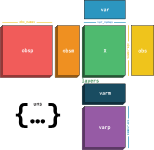

Note that...
* cell-wise metadata is stored in `adata.obs`
* dimensionality reductions (PCA, UMAP) are stored `adata.obsm`
* R layers are stored in `adata.layers` (as array objects)

Seurat's `SCTransform()` in R models the count data using "Pearson residuals from 'regularized negative binomial regression'" (see [here](https://link.springer.com/article/10.1186/s13059-019-1874-1?fromPaywallRec=false)). The data is transformed to a nonsparse object with only some of the genes from the original data (mostly highly variable genes that are then used for integration).

However, Anndata objects must have the same shape. Since the original data and SCTransform'd data have differing numbers of genes, they can't be grouped together.

original:
 [[8574.97568    8600.61413333]
 [4346.1578     6877.3512    ]
 [5647.2101     4414.481     ]
 [4653.871      7471.84715   ]
 [5673.9312     7209.43042   ]]

VS

flipped:
 [[ 8574.97568    -8600.61413333]
 [ 4346.1578     -6877.3512    ]
 [ 5647.2101     -4414.481     ]
 [ 4653.871      -7471.84715   ]
 [ 5673.9312     -7209.43042   ]]


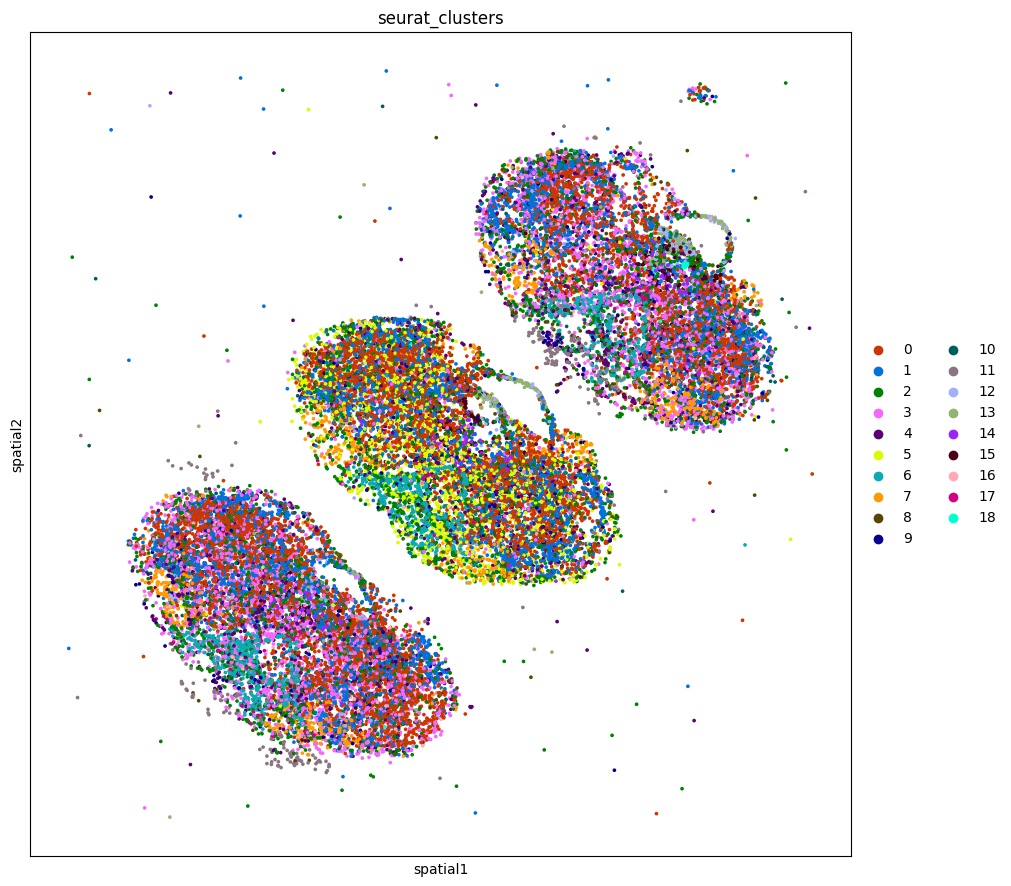

In [ ]:
# seurat R spatial Y-coords are inverted -- I think because R plots from top left, rather than bottom left
flipped = spatial.copy().T
flipped[1] = -flipped[1]
flipped = flipped.T
print("original:\n", spatial[:5])
print("\nVS\n")
print("flipped:\n", flipped[:5])
adata.obsm["spatial"] = flipped

f, ax = plt.subplots(1, 1, figsize=(10, 10), layout="constrained")
sc.pl.spatial(
    adata,
    spot_size=50,
    color=["seurat_clusters"],
    basis="spatial",
    img_key="None",
    palette=create_palette(len(adata.obs["seurat_clusters"].unique())),
    ax=ax,
)

In [ ]:
import squidpy as sq
import napari

# viewer = img.interactive(adata)

/mnt/DATA/home/ethung/spatial_seq/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/mnt/DATA/home/ethung/spatial_seq/.venv/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/mnt/DATA/home/ethung/spatial_seq/.venv/lib/python3.12/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_at

In [2]:
adata = sq.datasets.visium_hne_adata()
img = sq.datasets.visium_hne_image()

  0%|          | 0.00/380M [00:00<?, ?B/s]

In [ ]:
%gui qt5